In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
with uproot.open("../pythia/dataset_100k.root:fastjet") as f:
    print(f.keys())
    jet_pt  = f['jet_pt'].array()
    jet_eta = f['jet_eta'].array()
    jet_phi = f['jet_phi'].array()
    jet_m   = f['jet_m'].array()
    trk_pt  = f['trk_pt'].array()
    trk_eta = f['trk_eta'].array()
    trk_phi = f['trk_phi'].array()
    trk_m   = f['trk_m'].array()
    trk_q   = f['trk_q'].array()
    trk_d0  = f['trk_d0'].array()
    trk_z0  = f['trk_z0'].array()
    trk_origin  = f['trk_origin'].array()

['jet_pt', 'jet_eta', 'jet_phi', 'jet_m', 'trk_pt', 'trk_eta', 'trk_phi', 'trk_m', 'trk_q', 'trk_d0', 'trk_z0', 'trk_origin']


In [3]:
with uproot.open("../madgraph/labels.root:labels") as f:
    print(f.keys())
    top_px   = f['top_px'].array()
    top_py   = f['top_py'].array()
    top_pz   = f['top_pz'].array()
    top_E    = f['top_E'].array()
    down_px  = f['down_px'].array()
    down_py  = f['down_py'].array()
    down_pz  = f['down_pz'].array()
    down_E   = f['down_E'].array()
    costheta = f['costheta'].array()

['top_px', 'top_py', 'top_pz', 'top_E', 'down_px', 'down_py', 'down_pz', 'down_E', 'costheta']


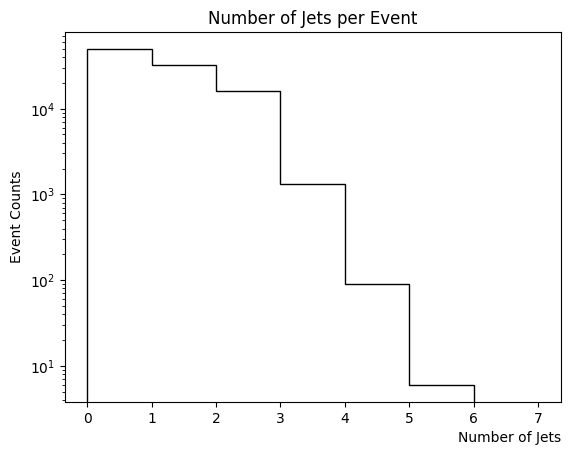

In [4]:
num_jets = ak.count(jet_pt,axis=1)
plt.title("Number of Jets per Event")
plt.hist(num_jets,range=(0,7),bins=7,histtype='step',color='k')
plt.yscale('log')
plt.ylabel('Event Counts')
plt.xlabel('Number of Jets',loc='right')
plt.show()

In [5]:
# Remove ALL events without a fat jet
no_jets = ak.num(jet_pt,axis=1)==0

jet_pt  = jet_pt[~no_jets]
jet_eta = jet_eta[~no_jets]
jet_phi = jet_phi[~no_jets]
jet_m   = jet_m[~no_jets]
trk_pt  = trk_pt[~no_jets]
trk_eta = trk_eta[~no_jets]
trk_phi = trk_phi[~no_jets]
trk_m   = trk_m[~no_jets]
trk_q   = trk_q[~no_jets]
trk_d0  = trk_d0[~no_jets]
trk_z0  = trk_z0[~no_jets]
trk_origin  = trk_origin[~no_jets]

top_px   = top_px[~no_jets]
top_py   = top_py[~no_jets]
top_pz   = top_pz[~no_jets]
top_E    = top_E[~no_jets]
down_px  = down_px[~no_jets]
down_py  = down_py[~no_jets]
down_pz  = down_pz[~no_jets]
down_E   = down_E[~no_jets]
costheta = costheta[~no_jets]

print("Percentage of Events with at least 1 jet: ", ak.mean(~no_jets))

Percentage of Events with at least 1 jet:  0.50305


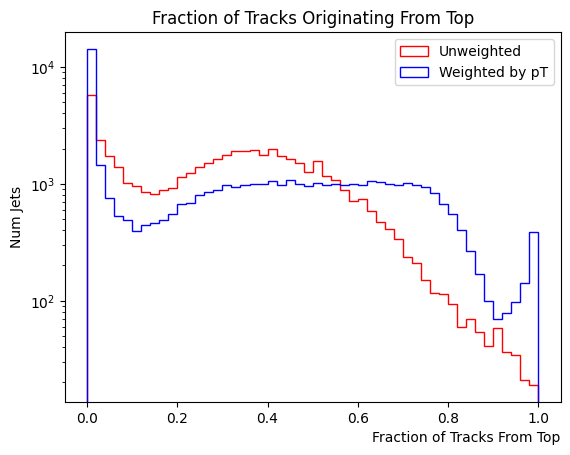

In [6]:
fromTop = trk_origin==6
unweighted = ak.mean(fromTop,axis=2)
weighted = ak.mean(fromTop,axis=2,weight=trk_pt)

unweighted = ak.max(unweighted,axis=1)
weighted = ak.max(weighted,axis=1)

plt.title("Fraction of Tracks Originating From Top")
plt.hist(unweighted,bins=50,range=(0,1),color='r',histtype='step',label="Unweighted")
plt.hist(weighted,bins=50,range=(0,1),color='b',histtype='step',label="Weighted by pT")
plt.yscale('log')
plt.ylabel('Num Jets')
plt.xlabel('Fraction of Tracks From Top',loc='right')
plt.legend()
plt.show()

In [7]:
cut = 0.1
mask = ak.max(ak.mean(trk_origin==6,axis=2,weight=trk_pt),axis=1)>cut
print("Percentage of Events that have one jet above cut:", ak.mean(mask))

Percentage of Events that have one jet above cut: 0.6533346585826458


In [8]:
jet_pt  = jet_pt[mask]
jet_eta = jet_eta[mask]
jet_phi = jet_phi[mask]
jet_m   = jet_m[mask]
trk_pt  = trk_pt[mask]
trk_eta = trk_eta[mask]
trk_phi = trk_phi[mask]
trk_m   = trk_m[mask]
trk_q   = trk_q[mask]
trk_d0  = trk_d0[mask]
trk_z0  = trk_z0[mask]
trk_origin  = trk_origin[mask]

top_px   = top_px[mask]
top_py   = top_py[mask]
top_pz   = top_pz[mask]
top_E    = top_E[mask]
down_px  = down_px[mask]
down_py  = down_py[mask]
down_pz  = down_pz[mask]
down_E   = down_E[mask]
costheta = costheta[mask]

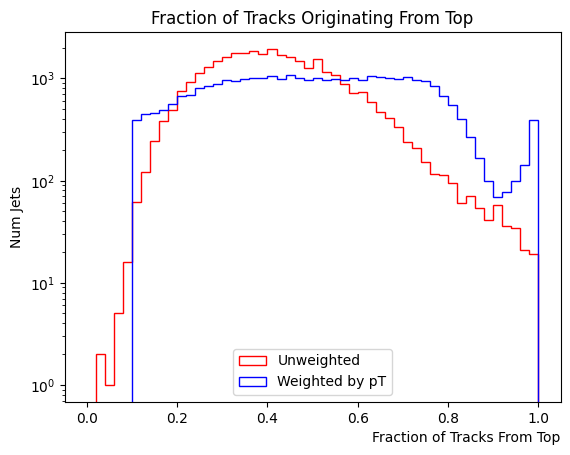

In [9]:
fromTop = trk_origin==6
unweighted = ak.mean(fromTop,axis=2)
weighted = ak.mean(fromTop,axis=2,weight=trk_pt)

unweighted = ak.max(unweighted,axis=1)
weighted = ak.max(weighted,axis=1)

plt.title("Fraction of Tracks Originating From Top")
plt.hist(unweighted,bins=50,range=(0,1),color='r',histtype='step',label="Unweighted")
plt.hist(weighted,bins=50,range=(0,1),color='b',histtype='step',label="Weighted by pT")
plt.yscale('log')
plt.ylabel('Num Jets')
plt.xlabel('Fraction of Tracks From Top',loc='right')
plt.legend()
plt.show()